In [1]:
import numpy as np
import os
import glob
import my_utils as myu  # Ensure 'myu' is properly defined or imported
from tqdm import tqdm
import concurrent.futures

In [2]:
# def read_all_vtks_and_interpolate(folder_path, grid_size=1.0):
#     # Updated pattern to generalize subfolder handling
#     all_vtk_files = glob.glob(os.path.join(folder_path, 'outputs/*.vtk'))

#     file_details = [(file, int(file.split('_')[-1].split('.')[0])) for file in all_vtk_files]
#     file_details_sorted = sorted(file_details, key=lambda x: x[1])

#     if not file_details_sorted:
#         raise ValueError("No VTK files found in the specified folder.")

#     # Determine the maximum file number dynamically
#     max_file_number = file_details_sorted[-1][1]

#     early_files = [file for file, num in file_details_sorted if 0 <= num <= 150000]
#     later_files = [file for file, num in file_details_sorted if 150001 <= num <= max_file_number]
#     early_selected = np.linspace(0, len(early_files) - 1, 5, dtype=int)
#     later_selected = np.linspace(0, len(later_files) - 1, 15, dtype=int)
#     vtk_files = [early_files[i] for i in early_selected] + [later_files[i] for i in later_selected]

#     total_files = len(vtk_files)
#     all_data = []

#     # for filename in tqdm(vtk_files, desc='Reading VTK files', unit='file'):
#     #     data = myu.read_mesh_cellCon(filename, 1, 0)
#     #     all_data.append(data)
#     folder_name = os.path.basename(folder_path)
    
#     for filename in tqdm(vtk_files, desc=f'Reading VTK files from {folder_name}', unit='file'):
#         data = myu.read_mesh_cellCon(filename, 1, 0)
#         all_data.append(data)

#     last_data_points = myu.read_mesh_cellCon(vtk_files[-1], 1, 0)[0]
#     min_x, min_y = np.min(last_data_points, axis=0)
#     max_x, max_y = np.max(last_data_points, axis=0)
#     x_coords = np.arange(min_x, max_x + grid_size, grid_size)
#     y_coords = np.arange(min_y, max_y + grid_size, grid_size)
#     grid_x, grid_y = np.meshgrid(x_coords, y_coords)
#     grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

#     last_theta = myu.read_mesh_cellCon(vtk_files[-1], 1, 0)[1]['theta']
#     interpolated_theta = myu.interpolate_features(last_data_points, {'theta': last_theta}, grid_points, k=3)['theta']

#     time_step_data = []
#     print("Starting interpolation of data across all files.")
#     for file_index, data in enumerate(tqdm(all_data, desc=f'Interpolating data from {os.path.basename(folder_path)}', unit='file')):
#         unique_points = data[0]
#         interpolated_step_data = {'theta': interpolated_theta.reshape(len(y_coords), len(x_coords))}
#         for field_name, values in data[1].items():
#             if field_name != 'theta':
#                 interpolated_values = myu.interpolate_features(unique_points, {field_name: values}, grid_points, k=3)
#                 interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
#                 interpolated_step_data[field_name] = interpolated_matrix      
#     # time_step_data = []
#     # print("Starting interpolation of data across all files.")
#     # # for file_index, data in enumerate(tqdm(all_data, desc='Interpolating data', unit='file')):
#     # with tqdm(all_data, desc=f'Interpolating data from {folder_name}', unit='file') as pbar:
#     #     unique_points = data[0]
#     #     interpolated_step_data = {'theta': interpolated_theta.reshape(len(y_coords), len(x_coords))}
#     #     for field_name, values in data[1].items():
#     #         if field_name != 'theta':
#     #             interpolated_values = myu.interpolate_features(unique_points, {field_name: values}, grid_points, k=3)
#     #             interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
#     #             interpolated_step_data[field_name] = interpolated_matrix

#         time_step_data.append(interpolated_step_data)

#     print("All files processed and interpolated.")
#     return time_step_data, grid_x, grid_y

# def process_all_cases(base_path):
#     cases_data = {}
#     subfolders = glob.glob(os.path.join(base_path, 'io2D_*'))
#     print(subfolders)
    
#     # Set up ThreadPoolExecutor to manage threads
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         # Create a future object for each folder processing task
#         future_to_subfolder = {executor.submit(read_all_vtks_and_interpolate, subfolder, 1.0): subfolder for subfolder in subfolders}
        
#         # Collect results as they are completed
#         for future in concurrent.futures.as_completed(future_to_subfolder):
#             subfolder = future_to_subfolder[future]
#             case_name = os.path.basename(subfolder)
#             try:
#                 time_step_interpolated_data, grid_x, grid_y = future.result()
#                 cases_data[case_name] = (time_step_interpolated_data, grid_x, grid_y)
#                 print(f"Processed {subfolder}...")
#             except Exception as exc:
#                 print(f"{subfolder} generated an exception: {exc}")

#     return cases_data

In [17]:
import numpy as np
import glob
import os
from tqdm import tqdm
import concurrent.futures
import my_utils as myu  # Ensure 'myu' is defined with necessary functions

def find_global_bounds(subfolders):
    """Calculate global bounds based on the 30th VTK file in the later files across all subfolders."""
    global_min_x, global_min_y = float('inf'), float('inf')
    global_max_x, global_max_y = float('-inf'), float('-inf')

    for subfolder in tqdm(subfolders, desc="Calculating global bounds"):
        vtk_files = glob.glob(os.path.join(subfolder, 'outputs/*.vtk'))
        file_details = [(file, int(file.split('_')[-1].split('.')[0])) for file in vtk_files]
        file_details_sorted = sorted(file_details, key=lambda x: x[1])

        # Focus only on files beyond the 150000 index
        later_files = [file for file, num in file_details_sorted if 150001 <= num]
        if later_files:
            # Ensure we have at least 20 files to choose from, then select the last (30th frame)
            if len(later_files) >= 20:
                later_selected = [later_files[i] for i in np.linspace(0, len(later_files) - 1, 20, dtype=int)]
                last_file = later_selected[-1]  # The 30th file from later selected
                data = myu.read_mesh_cellCon(last_file, 1, 0)
                if data:
                    points = data[0]
                    min_x, min_y = np.min(points, axis=0)
                    max_x, max_y = np.max(points, axis=0)
                    # Update global bounds across all subfolders
                    global_min_x = min(global_min_x, min_x)
                    global_min_y = min(global_min_y, min_y)
                    global_max_x = max(global_max_x, max_x)
                    global_max_y = max(global_max_y, max_y)

    return global_min_x, global_min_y, global_max_x, global_max_y

def interpolate_data_for_folder(folder_path, global_bounds, grid_size=1.0):
    """Interpolate selected VTK files within a folder using specified global bounds, with progress output."""
    global_min_x, global_min_y, global_max_x, global_max_y = global_bounds
    x_coords = np.arange(global_min_x, global_max_x + grid_size, grid_size)
    y_coords = np.arange(global_min_y, global_max_y + grid_size, grid_size)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

    interpolated_data = []
    all_vtk_files = glob.glob(os.path.join(folder_path, 'outputs/*.vtk'))
    file_details = [(file, int(file.split('_')[-1].split('.')[0])) for file in all_vtk_files]
    file_details_sorted = sorted(file_details, key=lambda x: x[1])
    
    early_files = [file for file, num in file_details_sorted if 0 <= num <= 150000]
    early_selected = [early_files[i] for i in np.linspace(0, len(early_files) - 1, 10, dtype=int)]
    later_files = [file for file, num in file_details_sorted if 150001 <= num]
    later_selected = [later_files[i] for i in np.linspace(0, len(later_files) - 1, 20, dtype=int)]
    selected_files = early_selected + later_selected

    folder_name = os.path.basename(folder_path)
    desc = f'Interpolating in {folder_name}'

    with tqdm(total=len(selected_files), desc=desc, unit='file') as progress:
        for filename in selected_files:
            data = myu.read_mesh_cellCon(filename, 1, 0)
            if data:
                points, fields, _, _ = data
                interpolated_step_data = {}
                for field_name, values in fields.items():
                    interpolated_values = myu.interpolate_features_cKD(points, {field_name: values}, grid_points, k=3)
                    interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
                    interpolated_step_data[field_name] = interpolated_matrix
                interpolated_data.append(interpolated_step_data)
            progress.update(1)

    return interpolated_data, grid_x, grid_y

def process_all_cases(base_path):
    subfolders = glob.glob(os.path.join(base_path, 'io2D_1c*'))
    global_bounds = find_global_bounds(subfolders)
    cases_data = {}

    for subfolder in subfolders:
        interpolated_data, grid_x, grid_y = interpolate_data_for_folder(subfolder, global_bounds)
        case_name = os.path.basename(subfolder)
        cases_data[case_name] = (interpolated_data, grid_x, grid_y)

    return cases_data

root_folder_path = "/mnt/e/NeuronGrowth_2024/TTNG_05052024"
all_cases_data = process_all_cases(root_folder_path)

Interpolating in io2D_1c01: 100%|██████████| 30/30 [00:27<00:00,  1.09file/s]

All cases have consistent dimensions for the 'phi' channel.


In [18]:
def check_consistent_dimensions(all_cases_data, channel='phi'):
    """
    Check if the dimensions of a specified channel are consistent across all cases in the dataset.

    Args:
        all_cases_data (dict): Dictionary containing all cases.
        channel (str): The name of the channel to check. Default is 'phi'.
    
    Returns:
        bool: True if dimensions are consistent, False otherwise.
    """
    # Initialize a variable to store the reference shape
    reference_shape = None

    for case, case_data in all_cases_data.items():
        try:
            current_shape = case_data[0][0][channel].shape  # Get the shape of the specified channel
            
            # Set the first shape as the reference shape
            if reference_shape is None:
                reference_shape = current_shape
            # Compare the current shape with the reference shape
            elif current_shape != reference_shape:
                print(f"Warning: Shape of '{channel}' in {case} is inconsistent. Expected {reference_shape}, but got {current_shape}.")
                return False
        except KeyError:
            print(f"Warning: '{channel}' not found in {case}.")
            return False

    print(f"All cases have consistent dimensions for the '{channel}' channel.")
    return True

# Example usage
consistent = check_consistent_dimensions(all_cases_data, channel='phi')


All cases have consistent dimensions for the 'phi' channel.


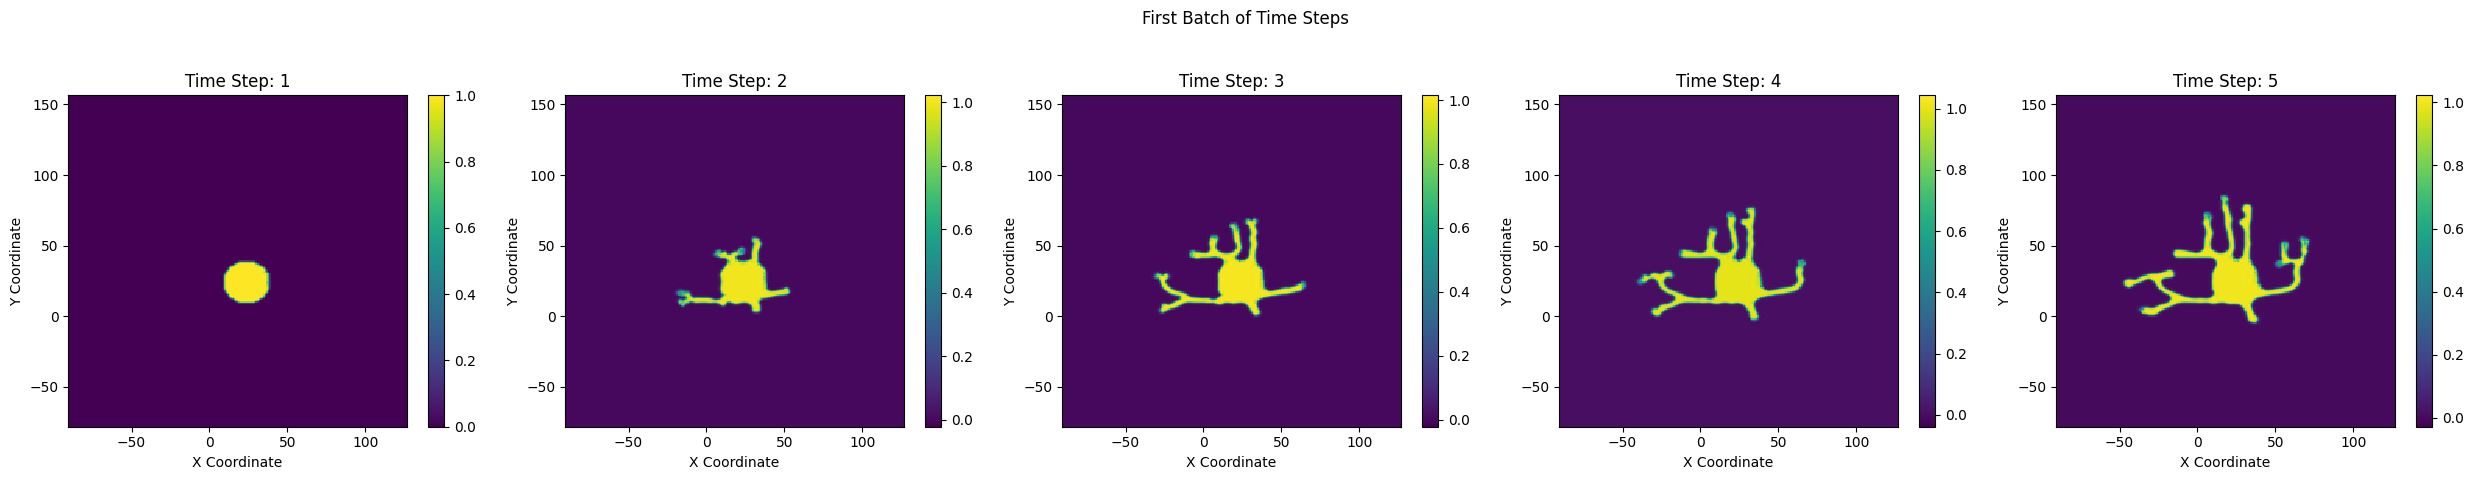

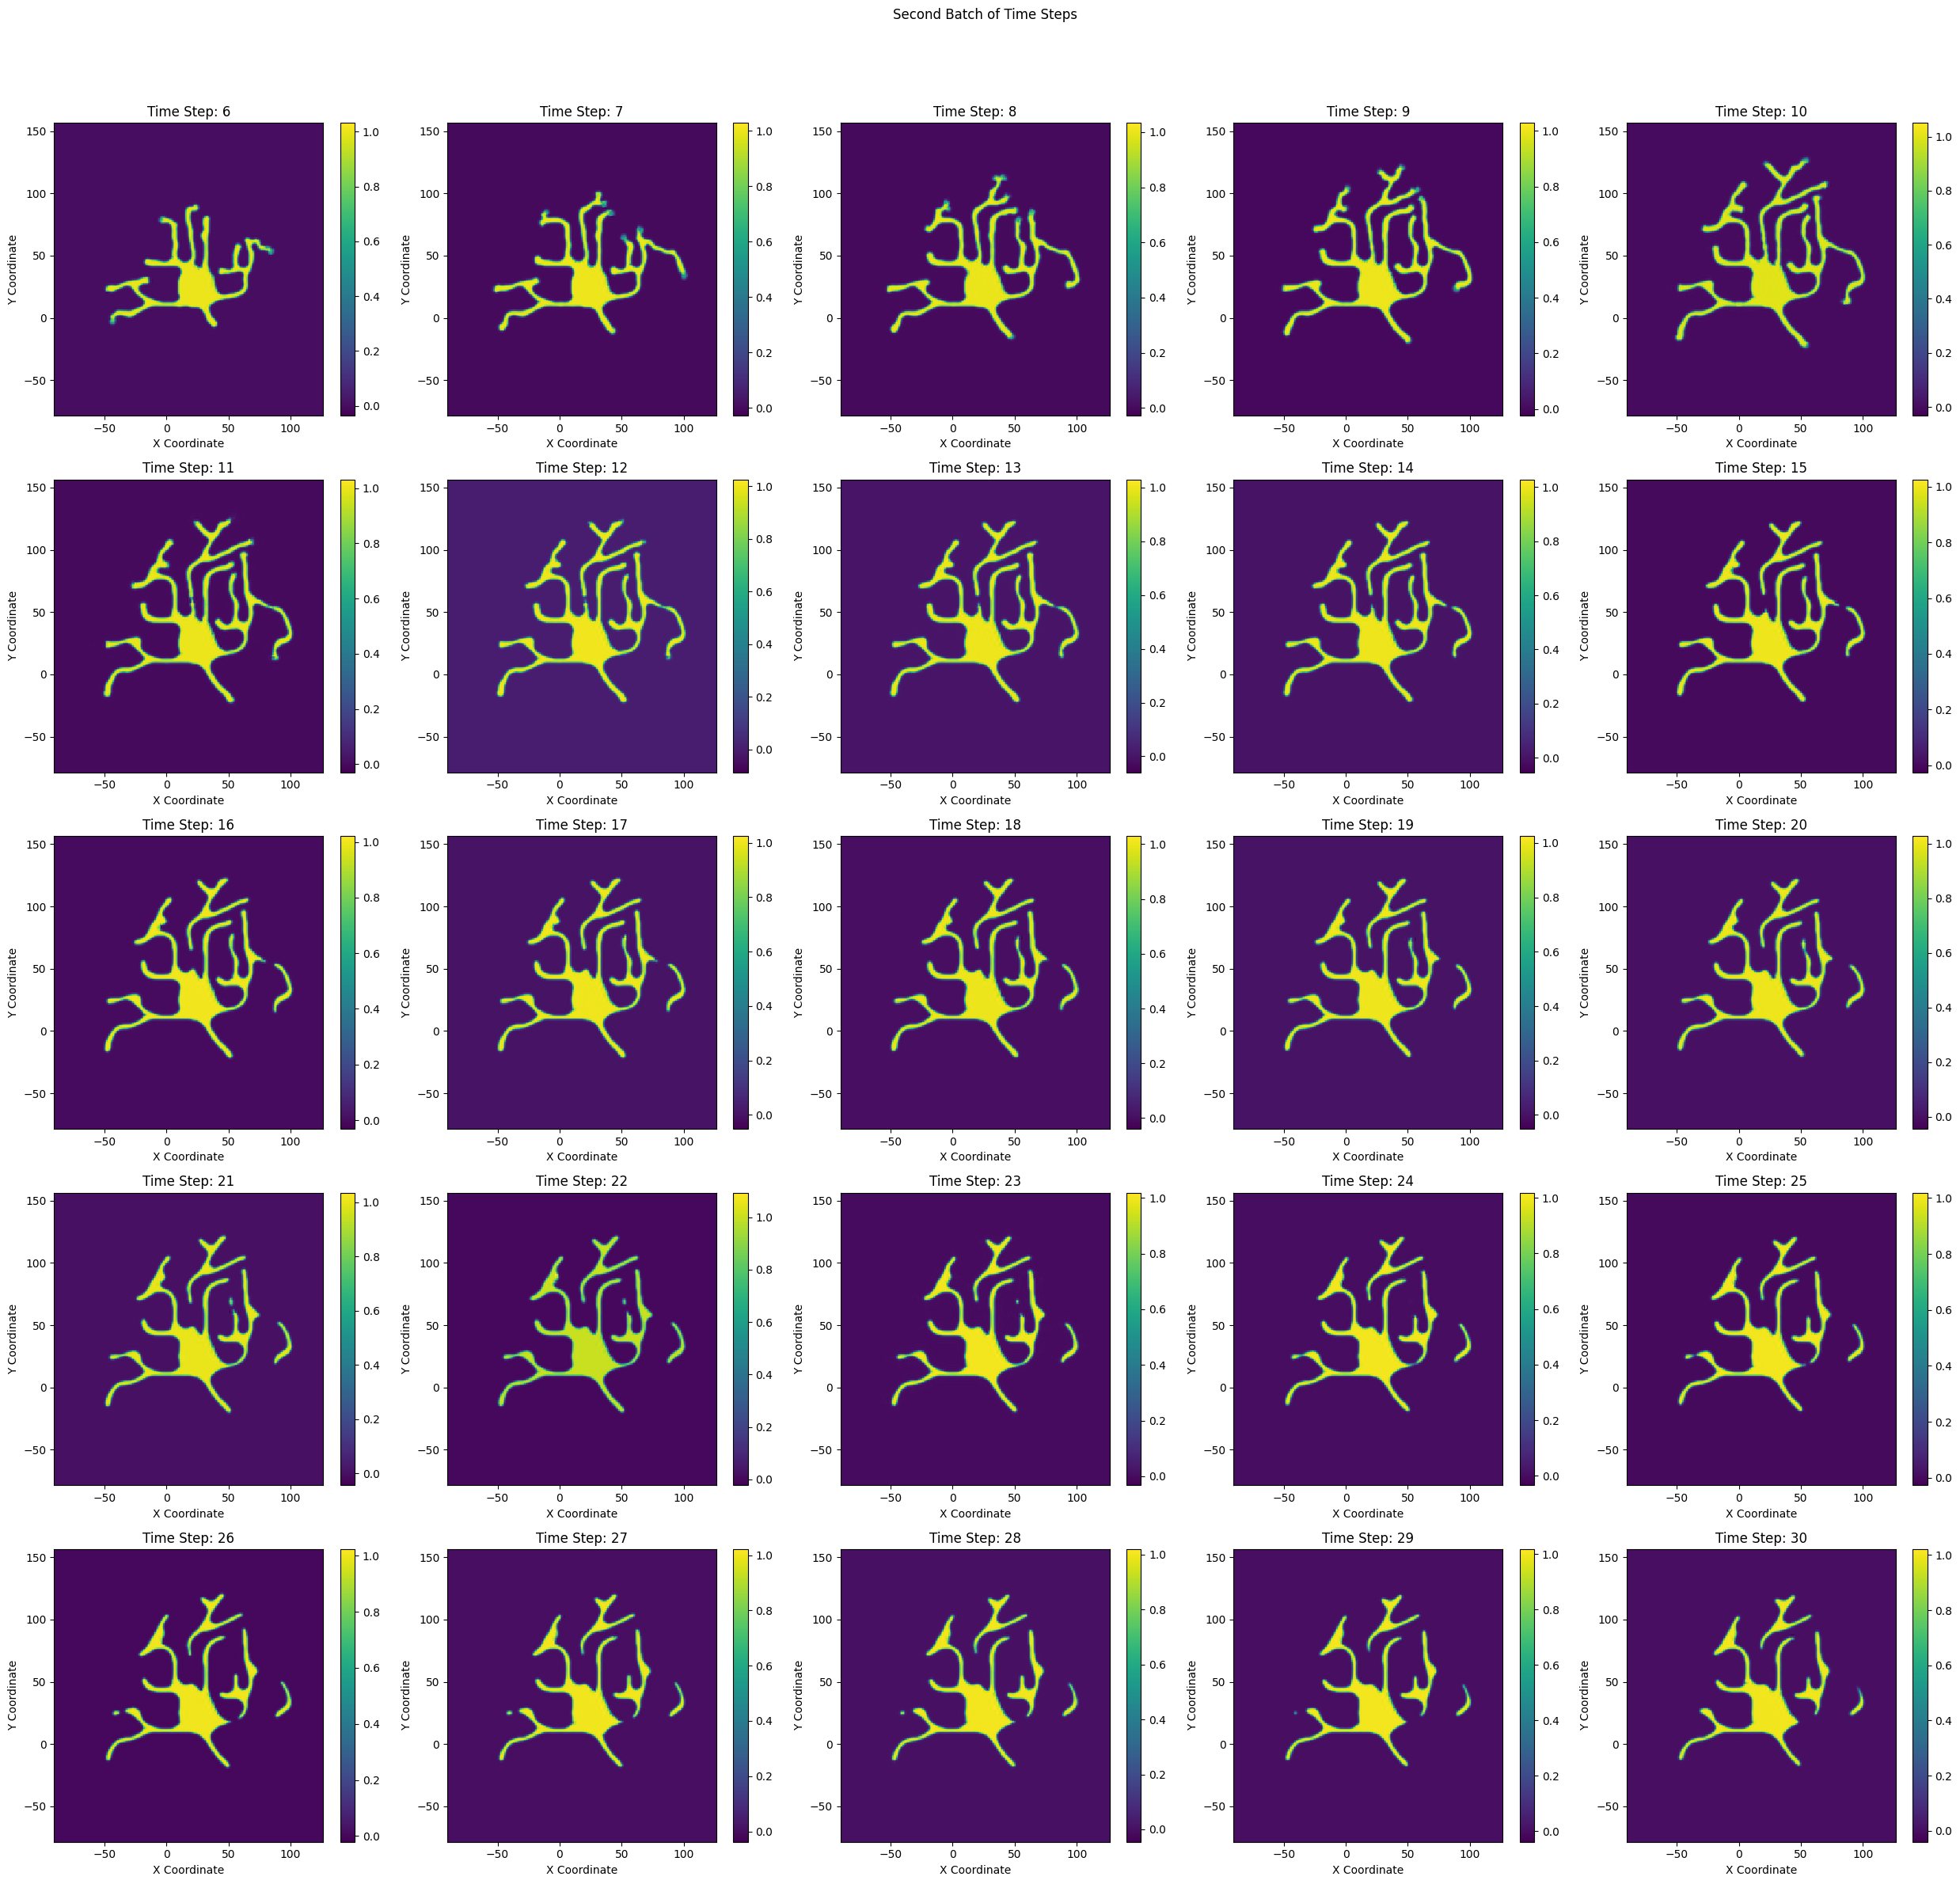

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_interpolated_time_steps(time_step_data, grid_x, grid_y, channel, split_at=5, columns_per_row=3):
    """
    Plots the specified channel from each time step's interpolated data, splitting the plots into two figures.

    Args:
        time_step_data (list of dicts): Each dict contains channel names as keys and 2D arrays of data as values.
        grid_x (np.array): 2D array of x coordinates for the grid.
        grid_y (np.array): 2D array of y coordinates for the grid.
        channel (str): Name of the channel to plot.
        split_at (int): Index at which to split the plots into a second figure.
        columns_per_row (int): Number of columns per row in the plot.

    Returns:
        None: Displays the plots.
    """
    num_time_steps = len(time_step_data)
    first_batch = min(num_time_steps, split_at)
    second_batch = num_time_steps - first_batch

    # Function to create plots for a given range of time steps
    def plot_batch(start_index, end_index, title):
        num_plots = end_index - start_index
        rows = (num_plots + columns_per_row - 1) // columns_per_row  # Calculate rows needed
        fig, axes = plt.subplots(rows, columns_per_row, figsize=(5 * columns_per_row, 5 * rows))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])  # Handle the case where there is only one subplot
        axes = axes.flatten()

        for i in range(num_plots):
            ax = axes[i]
            data_index = start_index + i
            if channel in time_step_data[data_index]:
                c = ax.pcolormesh(grid_x, grid_y, time_step_data[data_index][channel], shading='auto', cmap='viridis')
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Time Step: {data_index + 1}')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
            else:
                ax.set_title(f'Channel {channel} not found')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
                print(f"Warning: Channel '{channel}' not found in time step {data_index + 1}.")

        for j in range(i + 1, len(axes)):  # Hide unused axes
            axes[j].axis('off')

        plt.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Plot the first batch of time steps
    plot_batch(0, first_batch, "First Batch of Time Steps")

    # Plot the second batch of time steps if there are any
    if second_batch > 0:
        plot_batch(first_batch, num_time_steps, "Second Batch of Time Steps")

# Example usage assumes you have 'all_cases_data' with the appropriate data structure
case_key = 'io2D_1c02'  # This can be dynamically assigned based on your requirements
channel_to_plot = 'phi'  # Example channel to plot

# Now use the variable to access data and call the plotting function
plot_interpolated_time_steps(all_cases_data[case_key][0],
                             all_cases_data[case_key][1],
                             all_cases_data[case_key][2],
                             channel_to_plot,
                             columns_per_row=5)  # Adjust the number of columns per row as needed


In [15]:
import numpy as np
import random

def select_and_structure_data(all_cases_data, num_X_steps=10, num_Y_steps=20, train_frac=0.7, val_frac=0.15, channels=None):
    """
    Structured data extraction for ML training from multidimensional time-series data.

    Args:
        all_cases_data (dict): The main dataset containing all cases.
        num_X_steps (int): Number of time steps to use for X.
        num_Y_steps (int): Number of time steps to use for Y.
        train_frac (float): Fraction of data to be used for training.
        val_frac (float): Fraction of data to be used for validation.
        channels (list): List of channel names to include in the output arrays.

    Returns:
        dict: Dataset containing structured data for training, validation, and testing.
    """
    # Extract keys for all cases
    case_keys = list(all_cases_data.keys())
    random.shuffle(case_keys)

    # Determine split indices
    num_train = int(len(case_keys) * train_frac)
    num_val = int(len(case_keys) * val_frac)
    
    train_keys = case_keys[:num_train]
    val_keys = case_keys[num_train:num_train + num_val]
    test_keys = case_keys[num_train + num_val:]

    # Define function to extract data for X and Y
    def extract_data(cases, num_X_steps, num_Y_steps, channels):
        X, Y = [], []
        for case in cases:
            case_data = all_cases_data[case][0]  # Assuming the data structure is (list of dicts with channel data, grid_x, grid_y)
            if len(case_data) >= num_X_steps + num_Y_steps:
                x_segments = np.stack([np.array([time_step[channel] for time_step in case_data[:num_X_steps]]) for channel in channels if channel in case_data[0]], axis=1)
                y_segments = np.stack([np.array([time_step[channel] for time_step in case_data[num_X_steps:num_X_steps + num_Y_steps]]) for channel in channels if channel in case_data[0]], axis=1)

                X.append(x_segments)
                Y.append(y_segments)

        return np.array(X), np.array(Y)

    # Extract data for each dataset
    X_train, Y_train = extract_data(train_keys, num_X_steps, num_Y_steps, channels)
    X_val, Y_val = extract_data(val_keys, num_X_steps, num_Y_steps, channels)
    X_test, Y_test = extract_data(test_keys, num_X_steps, num_Y_steps, channels)

    return {
        'X_train': X_train, 'Y_train': Y_train,
        'X_val': X_val, 'Y_val': Y_val,
        'X_test': X_test, 'Y_test': Y_test
    }

# Example usage: specify which channels to include
# channels_to_include = ['phi', 'synaptogenesis', 'tubulin', 'tips', 'theta']  # Add your specific channels here
channels_to_include = ['phi']  # Add your specific channels here
dataset = select_and_structure_data(all_cases_data, channels=channels_to_include)

# Display the shapes of the datasets
for key in dataset:
    print(f"{key} shape: {dataset[key].shape if dataset[key].size else 'Empty'}")


X_train shape: (2, 10, 5, 235, 217)
Y_train shape: (2, 20, 5, 235, 217)
X_val shape: Empty
Y_val shape: Empty
X_test shape: (1, 10, 5, 235, 217)
Y_test shape: (1, 20, 5, 235, 217)


In [26]:
print(all_cases_data['io2D_1c01'][0][0]['phi'].shape)

(157, 193)


In [5]:
# import random
# import pickle
# import numpy as np

# def split_data_to_x_and_y(time_step_data):
#     """
#     Splits the time step data into two parts based on the number of frames: the first half becomes data_x and the second half becomes data_y.
#     """
#     total_frames = time_step_data.shape[0]  # Assumes time_step_data is an ndarray with shape (frames, channels, rows, cols)
#     midpoint = total_frames // 2
#     data_x = time_step_data[:midpoint]
#     data_y = time_step_data[midpoint:]
#     return data_x, data_y

# def process_cases(case_group, tags_to_exclude):
#     """
#     Processes the cases and returns datasets X and Y with the desired shape.
#     """
#     X_group, Y_group = [], []
#     for case_name in case_group:
#         time_step_data = np.array([step for step in all_cases_data[case_name] if step['tag'] not in tags_to_exclude])
#         # Assume each step is already in the shape (frames, channels, rows, cols)
#         data_x, data_y = split_data_to_x_and_y(time_step_data)
#         X_group.append(data_x)
#         Y_group.append(data_y)
#     return np.array(X_group), np.array(Y_group)

# def generate_dataset(all_cases_data, train_ratio=0.7, val_ratio=0.15, tags_to_exclude=['phi']):
#     """
#     Generates the dataset from all_cases_data, splits it into train, val, and test sets.
#     """
#     case_names = list(all_cases_data.keys())
#     random.shuffle(case_names)  # Shuffle for random distribution

#     # Compute the sizes for train, val, and test sets
#     train_size = int(len(case_names) * train_ratio)
#     val_size = int(len(case_names) * val_ratio)

#     # Split the case names into three groups
#     train_cases = case_names[:train_size]
#     val_cases = case_names[train_size:train_size + val_size]
#     test_cases = case_names[train_size + val_size:]

#     # Process each group
#     X_train, Y_train = process_cases(train_cases, tags_to_exclude)
#     X_val, Y_val = process_cases(val_cases, tags_to_exclude)
#     X_test, Y_test = process_cases(test_cases, tags_to_exclude)

#     return {
#         'X_train': X_train, 'Y_train': Y_train,
#         'X_val': X_val, 'Y_val': Y_val,
#         'X_test': X_test, 'Y_test': Y_test
#     }

# # Example usage assuming all_cases_data is structured appropriately
# # Generate and save the dataset
# dataset = generate_dataset(all_cases_data)
# with open('./reformatedNDDs/dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)
# print("Dataset saved to 'dataset.pkl'")

# # import random
# # import pickle
# # import numpy as np

# # def split_data_to_x_and_y(time_step_data):
# #     """
# #     Automatically splits time step data into two parts: the first half becomes data_x and the second half becomes data_y.

# #     Args:
# #         time_step_data (list of dicts): List of dictionaries, each containing channel data for one time step.

# #     Returns:
# #         data_x (list of dicts): The first half of time steps (splitting each key in the dictionary).
# #         data_y (list of dicts): The second half of time steps (splitting each key in the dictionary).
# #     """
# #     total_time_steps = len(time_step_data)

# #     # Calculate midpoint to split the data
# #     midpoint = total_time_steps // 2

# #     # Split time step data into two parts
# #     data_x = time_step_data[:midpoint]
# #     data_y = time_step_data[midpoint:]

# #     return data_x, data_y

# # def generate_dataset(all_cases_data, train_ratio=0.7, val_ratio=0.15):
# #     """
# #     Generates the dataset from the preprocessed all_cases_data, and splits it into train, val, and test sets.

# #     Args:
# #         all_cases_data (dict): Preprocessed data for each case, keyed by case names.
# #         train_ratio (float): Ratio of the total cases to assign to the training set.
# #         val_ratio (float): Ratio of the total cases to assign to the validation set.

# #     Returns:
# #         dataset (dict): Dictionary with 'X_train', 'Y_train', 'X_val', 'Y_val', 'X_test', 'Y_test' keys.
# #     """
# #     # Get the names of the cases
# #     case_names = list(all_cases_data.keys())
    
# #     # Shuffle the case names if you want a random distribution
# #     random.shuffle(case_names)  # Comment this line out if you don't want a random shuffle

# #     # Compute the sizes for train, val, and test sets
# #     total_cases = len(case_names)
# #     train_size = int(total_cases * train_ratio)
# #     val_size = int(total_cases * val_ratio)
# #     test_size = total_cases - train_size - val_size

# #     # Split the case names into three groups
# #     train_cases = case_names[:train_size]
# #     val_cases = case_names[train_size:train_size + val_size]
# #     test_cases = case_names[train_size + val_size:]

# #     dataset = {}

# #     # Function to process cases and assign them to the dataset
# #     def process_cases(case_group, group_name):
# #         X_group, Y_group = [], []
# #         for case_name in case_group:
# #             time_step_data = all_cases_data[case_name]
# #             data_x, data_y = split_data_to_x_and_y(time_step_data)
# #             X_group.append(data_x)
# #             Y_group.append(data_y)
        
# #         # Flatten the time steps across cases
# #         dataset['X_' + group_name] = X_group
# #         dataset['Y_' + group_name] = Y_group

# #     # Process each group
# #     process_cases(train_cases, 'train')
# #     process_cases(val_cases, 'val')
# #     process_cases(test_cases, 'test')

# #     print(f"Total cases: {total_cases}")
# #     print(f"Train cases: {len(train_cases)}, Val cases: {len(val_cases)}, Test cases: {len(test_cases)}")

# #     return dataset

# # # Generate the dataset, automatically dividing cases into train, val, and test sets
# # dataset = generate_dataset(all_cases_data)

# # # Save the dataset to a pickle file
# # with open('./reformatedNDDs/dataset.pkl', 'wb') as f:
# #     pickle.dump(dataset, f)

# # print("Dataset saved to 'dataset.pkl'")


# # with open('./reformatedNDDs/dataset.pkl', 'rb') as f:
# #     dataset = pickle.load(f)


TypeError: list indices must be integers or slices, not str

In [4]:
def print_dataset_structure(dataset):
    """
    Prints the structure of the dataset, including the shape and a sample of the data.

    Args:
        dataset (dict): The dataset generated from all_cases_data.
    """
    for key in dataset:
        print(f"\nKey: {key}")
        # Assuming each key in dataset is a list of lists of time steps
        group_data = dataset[key]  # This is a list of case data (time steps)
        print(f"Number of cases in {key}: {len(group_data)}")

        if len(group_data) > 0:
            # Print the shape of the first case's first time step for inspection
            first_case = group_data[0]
            print(f"Number of time steps in the first case: {len(first_case)}")
            if len(first_case) > 0:
                first_time_step = first_case[0]
                print(f"Shape of first time step's data:")
                for var_name, var_data in first_time_step.items():
                    print(f"  Variable '{var_name}': shape = {var_data.shape}")
                    print(f"  Sample data from '{var_name}': {var_data.flatten()[:5]}...")  # Print first 5 values as a sample

# After generating the dataset, print its structure
dataset = generate_dataset(all_cases_data)
print_dataset_structure(dataset)

# Optionally save the dataset to a pickle file
with open('dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

print("Dataset saved to 'dataset.pkl'")

NameError: name 'generate_dataset' is not defined